# Graph Convolution Network (GCN) for a classification problem

We will work with the CORA dataset from pytorch geometirc.
Each paper is assingned a high dimensional vector based on its contents
and we will work with the directed graph formed by the citations.
Each paper or node is classified based on research topic.

In [1]:
from torch_geometric.datasets import Planetoid

# Load the CORA dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# Access the first graph object
data = dataset[0]

In [2]:
print("No. of nodes = ", data['x'].shape[0])
print("No. of edges = ", data['edge_index'].shape[1])
print("Classification labels range from ", data['y'].min(), " to ", data['y'].max())

No. of nodes =  2708
No. of edges =  10556
Classification labels range from  tensor(0)  to  tensor(6)


To work with the jax ecosystem we will change the data type to a jax array

In [3]:
import jax.numpy as jnp

x = jnp.asarray(data['x'].numpy())
edge_index = jnp.asarray(data['edge_index'].numpy())
y = jnp.asarray(data['y'].numpy())

num_nodes = x.shape[0]
node_vector_size = x.shape[1]
num_classes = int(y.max()) + 1

We will use the edge index information to form the adjacency matrix which will be 2D jax array. Ideally we should use sparse matrices for efficiency.

In [4]:
A = jnp.zeros((num_nodes,num_nodes))
A = A.at[edge_index[0], edge_index[1]].set(1)


degree = A.sum(axis=0) # Check axis

print("Adjacency matrix of dimensions ", A.shape)
print("Min degree ", degree.min())
print("Max degree ", degree.max())

Adjacency matrix of dimensions  (2708, 2708)
Min degree  1.0
Max degree  168.0


Now we will use the gcn class built on equinox to transform the node features to vectors of size = number of classes. Initially the parameters of the transformation are set randomly.

In [5]:
import jax
from gcn import GCN

key = jax.random.PRNGKey(42)

model_key, key = jax.random.split(key)
gcn_transformation = GCN([node_vector_size, 100, 100, num_classes], model_key)

We will randomly select nodes for training. We will use one-hot encodings as target vectors.

In [6]:
num_of_nodes_in_training_set = int(0.2 * num_nodes)
training_set = jax.random.choice(key, num_nodes, (num_of_nodes_in_training_set,), replace=False)

Y = jnp.zeros((num_nodes, num_classes), dtype=int)
Y = Y.at[training_set,y[training_set]].set(1)

Now we can define our cross entropy loss function for the training set. To define the model, we apply the softmax function to the node embeddings we get as output. This is useful as we will generate one-hot encodings as our target output and use the cross-entropy function.

In [7]:
def loss_fn(gcn_transformation, x, A, degree, Y):
    z = gcn_transformation(x, A, degree)
    predicted_probs =  jax.nn.softmax(z, axis = 1)
    cross_entropy_terms = - Y * jnp.log(predicted_probs)
    return cross_entropy_terms.sum()

Now we begin the training process

In [8]:
import equinox as eqx
import optax

optim = optax.adam(learning_rate=1e-2)
opt_state = optim.init(gcn_transformation)

loss_values = []

for iter_id in range(500):
    value, grads = eqx.filter_value_and_grad(loss_fn)(gcn_transformation, x, A, degree, Y)
    print(f"{iter_id:03d} Loss = {value:.2e}")
    loss_values.append(value)
    
    updates, opt_state = optim.update(grads, opt_state)
    gcn_transformation = eqx.apply_updates(gcn_transformation, updates)

000 Loss = 1.27e+03
001 Loss = 1.13e+03
002 Loss = 1.07e+03
003 Loss = 1.02e+03
004 Loss = 9.83e+02
005 Loss = 9.49e+02
006 Loss = 9.22e+02
007 Loss = 9.06e+02
008 Loss = 8.85e+02
009 Loss = 8.69e+02
010 Loss = 8.56e+02
011 Loss = 8.42e+02
012 Loss = 8.21e+02
013 Loss = 8.04e+02
014 Loss = 7.87e+02
015 Loss = 7.70e+02
016 Loss = 7.59e+02
017 Loss = 7.43e+02
018 Loss = 7.26e+02
019 Loss = 7.12e+02
020 Loss = 7.00e+02
021 Loss = 6.89e+02
022 Loss = 6.80e+02
023 Loss = 6.70e+02
024 Loss = 6.59e+02
025 Loss = 6.49e+02
026 Loss = 6.39e+02
027 Loss = 6.30e+02
028 Loss = 6.21e+02
029 Loss = 6.10e+02
030 Loss = 6.02e+02
031 Loss = 5.92e+02
032 Loss = 5.83e+02
033 Loss = 5.76e+02
034 Loss = 5.69e+02
035 Loss = 5.63e+02
036 Loss = 5.59e+02
037 Loss = 5.54e+02
038 Loss = 5.50e+02
039 Loss = 5.47e+02
040 Loss = 5.45e+02
041 Loss = 5.42e+02
042 Loss = 5.39e+02
043 Loss = 5.36e+02
044 Loss = 5.30e+02
045 Loss = 5.26e+02
046 Loss = 5.23e+02
047 Loss = 5.20e+02
048 Loss = 5.17e+02
049 Loss = 5.14e+02


Now let us plot the loss plot

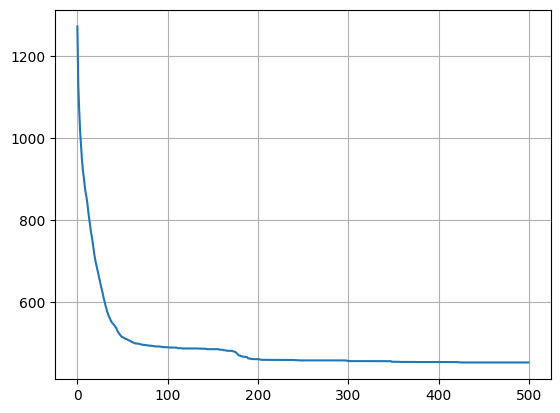

In [9]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.grid()
plt.show()